## Netflix Movie Recommendation System

## Problem Statement

Recommender system is about connecting people to products they love. <br>
The goal of my project is to create movie recommender system based on Netflix data


<img src="./images/woman.jpeg" alt="Drawing" style="width: 400px;"/>


## Content 

- Import libraries
- Data load
- Data Cleaning and EDA
- Theory of Recommendation Systems
- Modeling
    * KNN
    * SVDpp
    * Deep Learning 
    * Deep Learning with Metadata
- Conclusion


## Sources

- Datasets: https://www.kaggle.com/netflix-inc/netflix-prize-data , https://www.kaggle.com/rounakbanik/the-movies-dataset/home
- http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
- https://medium.com/datadriveninvestor/how-to-built-a-recommender-system-rs-616c988d64b2
- https://datajobs.com/data-science-repo/Recommender-Systems-%5bNetflix%5d.pdf
- https://nikhilwins.wordpress.com/2015/09/18/movie-recommendations-how-does-netflix-do-it-a-9-step-coding-intuitive-guide-into-collaborative-filtering/

- https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223
- https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
- https://medium.com/@julsimon/building-a-movie-recommender-with-factorization-machines-on-amazon-sagemaker-cedbfc8c93d8
- https://www.cs.cmu.edu/~mgormley/courses/10601-s17/slides/lecture25-mf.pdf
- http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/
- https://arxiv.org/pdf/1503.07475.pdf
- https://data-flair.training/blogs/data-science-at-netflix/
- https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a
- https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed
- https://medium.com/datadriveninvestor/recommendation-system-a-problem-statement-view-21efd20f2384
- https://surprise.readthedocs.io/en/stable/
- https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
- https://towardsdatascience.com/recommendation-systems-in-the-real-world-51e3948772f3

## Import libraries

In [1]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

import surprise as sp
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD, evaluate

from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

from scipy.sparse import vstack


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

Using TensorFlow backend.


## Load data

The Netflix Prize was an open competition for the best algorithm to predict user ratings for films, based on previous ratings without any other information about the users or films, i.e. without the users or the films being identified except by numbers assigned for the contest. <br>
Datasets were taken from https://www.kaggle.com/netflix-inc/netflix-prize-data and https://www.kaggle.com/rounakbanik/the-movies-dataset/home


**About Data:** <br>

There are 17 770 unique movie IDs. <br>
There are 480 189 unique user IDs. <br>
There are ratings. Ratings are on a five star (integral) scale from 1 to 5. <br>
Metadata of 44 500 movies

The first line of each file - combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt -  contains the movie id followed by a colon. Each subsequent line in the file corresponds to a customerID, rating from a customer and its date. <br> Below there is example of combined_data_*.txt and code to parse it.

**Example of combined_data_*.txt:** <br>
1: <br>
1488844,3,2005-09-06 <br>
822109,5,2005-05-13 <br>
... <br>

2: <br>
823519,3,2004-05-03 <br>
893988,3,2005-11-17 <br>
124105,4,2004-08-05 <br>
... <br>


In [2]:
#rewrite data from combined_data_*.txt to csv in format ['movie_id','user_id','rating', 'date']
data = open('./data/users_data.csv','a+') 
files = ['./data/combined_data_1.txt','./data/combined_data_2.txt',
         './data/combined_data_3.txt', './data/combined_data_4.txt']
for file in files:
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':', '') 
            else:
                row = [] 
                row = [x for x in line.split(',')] 
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
    print('file loading: '+ str(file) +' is completed')
data.close()

file loading: ./data/combined_data_1.txt is completed
file loading: ./data/combined_data_2.txt is completed
file loading: ./data/combined_data_3.txt is completed
file loading: ./data/combined_data_4.txt is completed


In [3]:
#create final dataset with users activity
ratings = pd.read_csv('./data/users_data.csv',
                      sep=',',
                      names = ['movie_id','user_id','rating', 'date'])
ratings.head()

,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03


In [4]:
#load movies file
movies = pd.read_csv('./data/movie_titles.csv', 
                        encoding = 'ISO-8859-1', 
                        header = None, 
                        names = ['movie_id', 'year', 'name']).set_index('movie_id')
movies.head()

,year,name
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [5]:
#load movies metadata
movies_metadata = pd.read_csv('./data/movies_metadata.csv')
movies_metadata = movies_metadata[['original_title', 'overview', 'vote_count']].set_index('original_title').dropna()
movies_metadata.head()

,overview,vote_count
original_title,,
Toy Story,"Led by Woody, Andy's toys live happily in his ...",5415.0
Jumanji,When siblings Judy and Peter discover an encha...,2413.0
Grumpier Old Men,A family wedding reignites the ancient feud be...,92.0
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0
Father of the Bride Part II,Just when George Banks has recovered from his ...,173.0


## Cleaning and EDA

**Shape**

In [6]:
#check shape of data
print(f'ratings shape: {ratings.shape}')
print(f'movies shape: {movies.shape}')
print(f'movies metadata shape: {movies_metadata.shape}')

ratings shape: (100480507, 4)
movies shape: (17770, 2)
movies metadata shape: (44506, 2)


**Null values**

In [7]:
#check null values
ratings.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [8]:
movies.isnull().sum() #7 null values in Year, I will ignore it

year    7
name    0
dtype: int64

In [9]:
movies_metadata.isnull().sum()

overview      0
vote_count    0
dtype: int64

**Data Types**

In [10]:
#check data types
ratings.dtypes

movie_id     int64
user_id      int64
rating       int64
date        object
dtype: object

Convert Date to Datetime format:

In [11]:
ratings['date'] = pd.to_datetime(ratings['date'])
ratings.sort_values(by = 'date', inplace = True)

**Duplicates**

In [12]:
ratings.duplicated(['movie_id','user_id','rating']).sum()

0

**EDA**

In [13]:
print(f'Total number of movie ratings = {ratings.shape[0]}')
print(f'Number of unique users = {len(np.unique(ratings["user_id"]))}')
print(f'Number of unique movies = {len(np.unique(ratings["movie_id"]))}')
print(f'Average overall rating = {ratings["rating"].mean()}')

Total number of movie ratings = 100480507
Number of unique users = 480189
Number of unique movies = 17770
Average overall rating = 3.604289964420661


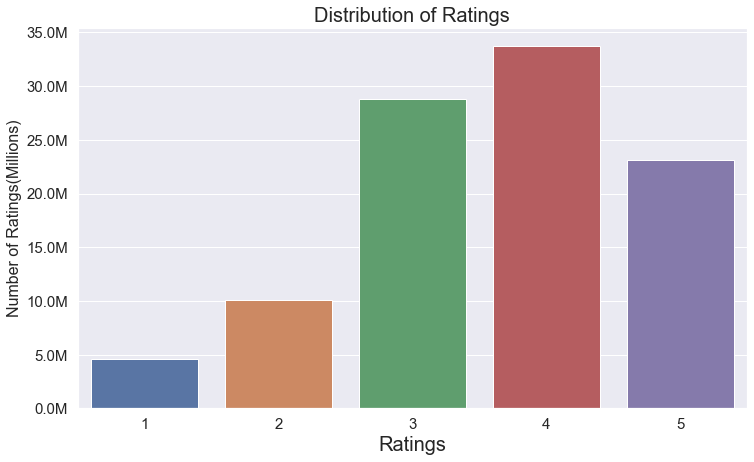

In [14]:
plt.figure(figsize = (12,7))

ax = sns.countplot(x='rating', data=ratings)
ax.set_yticklabels([str(num/10**6) + 'M' for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title('Distribution of Ratings', fontsize = 20)
plt.xlabel('Ratings', fontsize = 20)
plt.ylabel('Number of Ratings(Millions)', fontsize = 16)
plt.show()

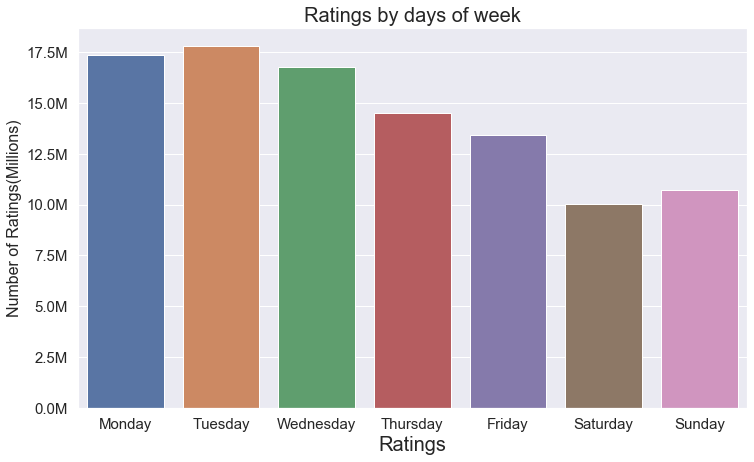

In [15]:
ratings['day'] = ratings['date'].dt.weekday_name
plt.figure(figsize = (12,7))

ax = sns.countplot(x='day',
                   data=ratings,
                   order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax.set_yticklabels([str(num/10**6) + 'M' for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title('Ratings by days of week', fontsize = 20)
plt.xlabel('Ratings', fontsize = 20)
plt.ylabel('Number of Ratings(Millions)', fontsize = 16)
plt.show()

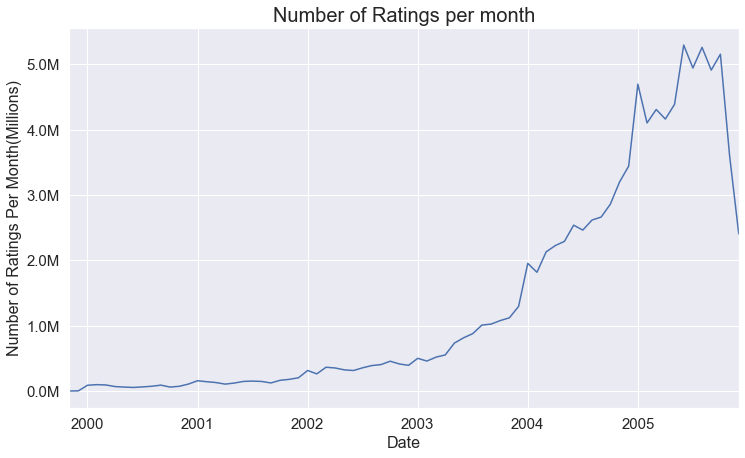

In [16]:
plt.figure(figsize = (12,7))
ax = ratings.resample('M', on = 'date')['rating'].count().plot()

ax.set_yticklabels([str(num/10**6) + 'M' for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 16)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 16)
plt.tick_params(labelsize = 15)
plt.show()

In [17]:
average_rating_per_user = pd.DataFrame(ratings.groupby('user_id')['rating'].mean().round(1).reset_index())

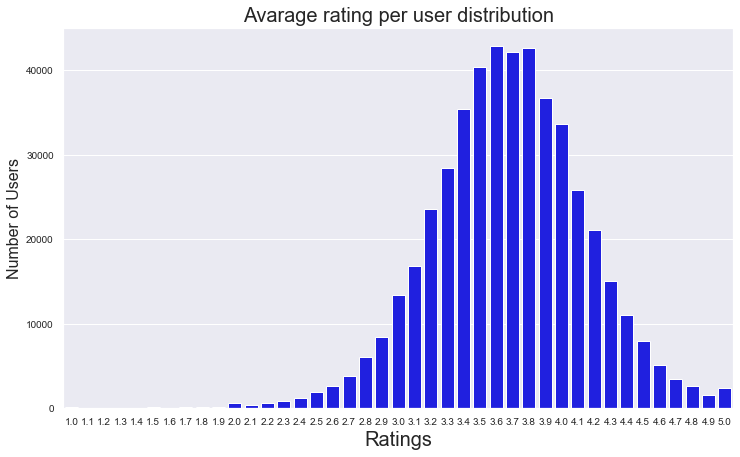

In [18]:
plt.figure(figsize = (12,7))

ax = sns.countplot(x='rating',
                   data=average_rating_per_user,
                   color='blue')

plt.tick_params(labelsize = 10)
plt.title('Avarage rating per user distribution', fontsize = 20)
plt.xlabel('Ratings', fontsize = 20)
plt.ylabel('Number of Users', fontsize = 16)
plt.show()

The mean rating is 3.604 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill is not a good indicator as people could have different rating styles (one person could always use 4 for an average movie, where another person only gives 4 out for their favorites). <br>
Users grouped by their average rating are normally distributed.
Every month the number of ratings is growing and this allows to create better and better recommender systems.

## Theory of Recommendation Systems

Broadly speaking, recommender systems are based on one of two strategies. <br><br>
**Content-based recommendation**: Users or items have profiles describing their characteristics and the system would recommend an item to a user if the two profiles match. 

At Pandora, a team of musicians labeled each music with more than 400 attributes. Then when a user selects a music station, songs that match the station’s attributes will be added to the playlist (Music Genome Project|Pandora, Howe|Pandora).

Content-based methods are computationally fast and interpretable. They can be easily adapted to new items or new users. However, some characteristics of items/users may not be easy to capture or describe explicitly.




An alternative to content filtering relies is **collaborative filtering** systems.
Collaborative filtering systems make recommendations based on historic users’ preference for items (clicked, watched, purchased, liked, rated, etc.). The preference can be presented as a user-item matrix. Here is an example of a matrix describing the preference of 4 users on 5 items, where p_{12} is the user 1’s preference on item 2.
<img src="./images/mat.png" alt="Drawing" style="width: 500px;"/>

Although the entries can be numeric, e.g., Netflix’s movie rating prediction challenge (rating ranges from 1 to 5), in most applications, they are binary (e.g., clicked, watched, purchased).
In reality, the user-item matrix can be more than millions * millions (e.g., Amazon, Youtube), and the majority of entries are missing — the goal of recommender systems is to fill those missing entries.

<img src="./images/matrix.png" alt="Drawing" style="width: 500px;"/>



Three the most popular collaborative-filtering-related approaches are nearest-neighbor, and two methods creating a new latent space: matrix factorization and deep learning.
**In my project I used all 3 approaches**









Latent-factor methods create a new and usually reduced feature space of the original user or item vectors, leading to reduced noise and faster computations in real-time.
In the following, we introduce two latent-factor methods — matrix factorization and deep learning.
Matrix factorization was popularly used during the Netflix recommendation challenge, especially singular value decomposition and a more practical version for recommender systems.
Singular value decomposition (SVD) decomposes the preference matrix as <br>
<img src="./images/1.png" alt="Drawing" style="width: 500px;"/>
U and V are unitary matrices. For 4 users and 5 items, it looks like

<img src="./images/2.png" alt="Drawing" style="width: 500px;"/>

where sigma_1 > sigma_2 > sigma_3 > sigma_4.

The preference of the first user for the first item can be written as <br>
<img src="./images/3.png" alt="Drawing" style="width: 500px;"/>



**Deep learning** is more flexible (than matrix factorization) in including various factors into modeling and creating embeddings. For example, deep learning was used to model sequential information by leveraging the skip-gram model, originally used for calculating word similarity. (Airbnb|2018, Zillow|2018)
Say, a user’s item sequence is item1 -> item2 -> item 3 -> item4 -> … The intuition is to use each item in the sequence to predict its neighboring items, formulated as a classification problem, where each item is one class. The training data include the neighboring K items of each item (the left K and right K items). The following figure illustrates the pairs of items with K = 1.

<img src="./images/dl0.png" alt="Drawing" style="width: 500px;"/>

Furthermore, each item is represented as a one-hot vector that has a length equal to the number of items. A neural network takes an item one-hot vector as the input and output the vector of one of its similar items, illustrated in the following figure, using (Item2, Item1) as the training example.
The hidden layer is the new feature space (or latent space), and each item can be transferred to the new feature space using the weights between the input layer and the hidden layer (essentially a linear combination of the original features).

<img src="./images/dl1.png" alt="Drawing" style="width: 500px;"/>

In reality, there can be millions of items, and billions of examples are used to train the network. To simplify the calculation, the negative sampling idea can be applied. The idea is to update only the weights of the output item (Item 1) and a small number of other items randomly sampled. In the following, we highlight the items and the weights need to be updated. It makes the calculation much faster.



<img src="./images/dl2.png" alt="Drawing" style="width: 500px;"/>

Once each item is represented in the new feature space, the similarity between items can be calculated, and recommendations can be made based on similarity scores.
In some cases, users visit a sequence of items before conversion, e.g., an Amazon user makes a purchase after a sequence of page views; An Airbnb user books a listing after viewing a few listings. This information can be included by adding the purchased item to every item’s training pair (Airbnb|2018), shown in the figure below. Items recommended in this way could improve the conversion rates.



Accurate recommendations cannot be made for new users/items with no or little information. This is referred to as the **cold start problem**. This is a typical issue for collaborative filtering systems that rely on user-item interactions. Some heuristics can be used. For a new user, the most popular items in the user’s area could be recommended. For a new item, some rule-based similarity criteria can be defined. For example, Airbnb used the average of 3 geographically closest listings of the same type and price range to approximate a new listing (Airbnb|2018).


Credits: https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a

## Modeling

For modeling in Jupyter Notebook I will use sample of the dataset, later on AWS I'll use full dataset.

In [19]:
ratings_sample = ratings.sample(7_000_000)

In [20]:
#save sample in case kernel dies 
ratings_sample.to_csv('./data/users_data_sample.csv')

In [21]:
ratings_sample.shape

(7000000, 5)

### Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.

In [22]:
min_movie_ratings = 1000
filter_movies = (ratings_sample['movie_id'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 100
filter_users = (ratings_sample['user_id'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
filtred_ratings = ratings_sample[(ratings_sample['movie_id'].isin(filter_movies)) & (ratings_sample['user_id'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(ratings_sample.shape))
print('Shape User-Ratings filtered:\t{}'.format(filtred_ratings.shape))

Shape User-Ratings unfiltered:	(7000000, 5)
Shape User-Ratings filtered:	(302671, 5)


In [23]:
print(f'Total number of movie ratings = {filtred_ratings.shape[0]}')
print(f'Number of unique users = {len(np.unique(filtred_ratings["user_id"]))}')
print(f'Number of unique movies = {len(np.unique(filtred_ratings["movie_id"]))}')
print(f'Average overall rating = {filtred_ratings["rating"].mean()}')

Total number of movie ratings = 302671
Number of unique users = 4450
Number of unique movies = 1613
Average overall rating = 3.4978970565399394


### Train Test Split

In [24]:
n = int(filtred_ratings.shape[0] *0.8)
train = filtred_ratings[:n]
test = filtred_ratings[n:]
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (242136, 5)
test shape: (60535, 5)


The trainset will be used to train all models and the testset ensures comparibility between all models with the RMSE metric.

### Transform The User-Ratings To User-Movie-Matrix


Each row will represent a user and its ratings and the columns are the movies.

Empty values are unrated movies and could contain high values and therefore should be good recommendations for the respective user.
**The goal is to estimate the empty values to help our users.**

In [25]:
#user-movie matrix with empty values
df_p = train.pivot_table(index='user_id', columns='movie_id', values='rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.head()

Shape User-Movie-Matrix:	(4450, 1613)


movie_id,8,28,30,58,83,108,111,118,143,148,175,187,191,197,199,223,241,252,257,269,270,273,290,295,299,311,312,313,329,330,331,334,353,357,361,406,413,424,442,443,457,468,473,482,483,494,501,516,528,550,571,607,658,660,686,692,705,708,711,720,746,758,759,788,789,798,818,819,831,851,862,872,886,896,937,940,962,963,985,989,1020,1027,1035,1046,1050,1066,1073,1102,1110,1138,1144,1145,1148,1174,1180,1202,1220,1255,1267,1289,1305,1307,1314,1324,1367,1406,1425,1428,1435,1466,1467,1470,1482,1495,1509,1542,1561,1571,1578,1585,1590,1595,1615,1625,1637,1642,1645,1650,1659,1661,1682,1700,1703,1709,1719,1744,1754,1770,1798,1799,1803,1810,1832,1833,1843,1861,1865,1877,1884,1890,1901,1902,1905,1918,1962,1974,1975,1983,2000,2001,2009,2012,2015,2016,2072,2095,2112,2122,2128,2136,2139,2152,2153,2162,2163,2171,2172,2173,2178,2186,2192,2200,2209,2212,2252,2254,2290,2329,2342,2348,2360,2371,2372,2376,2389,2391,2395,2400,2430,2443,2452,2456,2457,2462,2465,2470,2495,2499,2519,2554,2577,2578,2580,2594,2612,2617,2660,2675,2680,2690,2699,2734,2743,2751,2755,2779,2780,2782,2783,2800,2803,2809,2848,2851,2862,2866,2874,2890,2905,2913,2920,2922,2938,2942,2953,2960,2992,3015,3017,3046,...,15107,15110,15114,15116,15124,15129,15151,15156,15163,15182,15205,15209,15233,15234,15296,15307,15339,15342,15345,15366,15373,15381,15385,15393,15394,15409,15421,15422,15424,15425,15429,15436,15440,15445,15449,15450,15465,15471,15472,15496,15531,15532,15540,15545,15563,15578,15582,15646,15662,15671,15674,15689,15700,15702,15712,15715,15733,15755,15758,15764,15769,15777,15788,15807,15813,15815,15816,15818,15843,15844,15853,15887,15894,15902,15919,15922,15952,15953,15955,15956,15997,16002,16008,16016,16047,16052,16063,16068,16075,16082,16113,16118,16128,16139,16147,16150,16158,16169,16181,16201,16203,16222,16223,16236,16242,16262,16265,16272,16286,16302,16303,16306,16325,16339,16343,16357,16363,16377,16380,16384,16390,16406,16415,16438,16452,16459,16465,16469,16499,16516,16522,16532,16538,16552,16565,16572,16587,16596,16604,16605,16606,16640,16644,16668,16698,16703,16707,16711,16721,16740,16760,16765,16767,16784,16788,16792,16793,16825,16859,16872,16879,16882,16891,16901,16912,16922,16930,16948,16954,16969,16977,16984,16992,16997,17002,17004,17008,17023,17031,17053,17057,17064,17085,17088,17129,17134,17136,17149,17154,17157,17169,17174,17176,17179,17189,17195,17207,17215,17221,17251,17281,17293,17295,17299,17302,17308,17319,17321,17324,17328,17330,17339,17346,17355,17358,17361,17381,17387,17398,17405,17424,17426,17431,17441,17449,17474,17479,17482,17499,17506,17508,17513,17526,17533,17537,17541,17558,17560,17580,17589,17621,17622,17627,17671,17672,17692,17703,17709,17762,17764
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Transforming Data for Surprise Models

In [26]:
#Surprise library require separate format for TRAIN and TEST data
#Train:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], reader)
trainset = data.build_full_trainset()
#Test:
testset = list(zip(test['user_id'].values, test['movie_id'].values, test['rating'].values))

## KNN-Baseline with User-User

In [27]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"],
                              "user_based": [True],
                              "min_support": [2],
                              "shrinkage": [60]}, #[60, 80, 80, 140]
               'k': [80]} #[5, 20, 40, 80]

gs = GridSearchCV(sp.KNNBaseline, 
                  param_grid,
                  measures=['rmse'],
                  cv=3)

gs.fit(data)


print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0.9643820052410009
{'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2, 'shrinkage': 60}, 'k': 80}


In [28]:
sim_options = {'name':'pearson_baseline', 
               'user_based':True, 
               'min_support':2, 
               'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

knn_best = sp.KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)


knn_best.fit(trainset)

train_pred = knn_best.test(trainset.build_testset())
train_actual = np.array([pred.r_ui for pred in train_pred])
train_predicted = np.array([pred.est for pred in train_pred])

test_pred = knn_best.test(testset)
test_actual = np.array([pred.r_ui for pred in test_pred])
test_predicted = np.array([pred.est for pred in test_pred])

rmse_train = np.sqrt(mean_squared_error(train_actual, train_predicted)) 
r2_score_train = r2_score(train_actual, train_predicted)
rmse_test = np.sqrt(mean_squared_error(test_actual, test_predicted)) 
r2_score_test = r2_score(test_actual, test_predicted)


print("RMSE Train = {}".format(rmse_train))
print("R2 Train = {}".format(r2_score_train))
print("RMSE Test = {}".format(rmse_test))
print("R2 Test = {}".format(r2_score_test))

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE Train = 0.24645534214811557
R2 Train = 0.946727323934334
RMSE Test = 0.9176860825199141
R2 Test = 0.2705299051520119


In [29]:
sim_options

{'name': 'pearson_baseline',
 'user_based': True,
 'min_support': 2,
 'shrinkage': 60}

## Matrix Factorization - SVDpp 

The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to Probabilistic Matrix Factorization

In [30]:
param_grid = {'n_factors': [10,30,50], # [10, 30, 50, 80, 100]
              'lr_all': [0.002, 0.006, 0.018, 0.054]} #[0.002, 0.006, 0.018, 0.054, 0.10]

gs = GridSearchCV(sp.SVDpp,
                  param_grid, 
                  measures=['rmse'], 
                  cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9204186660178566
{'n_factors': 10, 'lr_all': 0.006}


In [36]:
svdpp_best = sp.SVDpp(n_factors = gs.best_params['rmse']['n_factors'], 
                   lr_all = gs.best_params['rmse']['lr_all'],
                   verbose=False)

svdpp_best.fit(trainset)

train_pred = svdpp_best.test(trainset.build_testset())
train_actual = np.array([pred.r_ui for pred in train_pred])
train_predicted = np.array([pred.est for pred in train_pred])

test_pred = svdpp_best.test(testset)
test_actual = np.array([pred.r_ui for pred in test_pred])
test_predicted = np.array([pred.est for pred in test_pred])

rmse_train = np.sqrt(mean_squared_error(train_actual, train_predicted)) 
r2_score_train = r2_score(train_actual, train_predicted)
rmse_test = np.sqrt(mean_squared_error(test_actual, test.mean(rating))) 
r2_score_test = r2_score(test_actual, test_predicted)


print("RMSE Train = {}".format(rmse_train))
print("R2 Train = {}".format(r2_score_train))
print("RMSE Test = {}".format(rmse_test))
print("R2 Test = {}".format(r2_score_test))

KeyboardInterrupt: 

In [45]:
len(train_predicted)

242136

In [55]:
r = np.full((60535), 3.4939, dtype=int)

In [43]:
test.rating.mean()

3.4939621706450814

In [54]:
len(test_predicted)

60535

In [56]:
rmse_test = np.sqrt(mean_squared_error(test_actual, r))

In [57]:
rmse_test

1.1825665726235923

## Deep Learning 

With its embedding layers this is similar to the matrix factorization approach above, but instead of using a fixed dot-product as recommendation we will utilize some **dense layers so the network can find better combinations.**

In [32]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(filtred_ratings['user_id'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(filtred_ratings['movie_id'].unique())}

# Create correctly mapped train- & testset
train_user_data = train['user_id'].map(user_id_mapping)
train_movie_data = train['movie_id'].map(movie_id_mapping)

test_user_data = test['user_id'].map(user_id_mapping)
test_movie_data = test['movie_id'].map(movie_id_mapping)

# Get input variable-sizes
users = len(user_id_mapping)
movies_cnt = len(movie_id_mapping)

# Setup variables
user_embedding_size = 20
movie_embedding_size = 10

##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embedding_size, 
                            input_dim=movies_cnt,
                            input_length=1, 
                            name='item_embedding')(movie_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
movie_vector = Reshape([movie_embedding_size])(movie_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, movie_vector])

# Combine with dense layers
dense = Dense(256)(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, 
                      movie_id_input], 
                      outputs=y)
model.compile(loss='mse',
              optimizer='adam')


# Fit model
model.fit([train_user_data, train_movie_data],
          train['rating'],
          batch_size=256, 
          epochs=3,
          validation_split=0.1,
          shuffle=True)

## Train model
y_pred_train = model.predict([train_user_data, train_movie_data])
y_true_train= train['rating'].values

# Test model
y_pred_test = model.predict([test_user_data, test_movie_data])
y_true_test = test['rating'].values

#Evaluate
rmse_test = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_true_test))
rmse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_true_train))
print(f'Train RMSE{rmse_train}')
print(f'Test RMSE{rmse_test}')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 217922 samples, validate on 24214 samples
Epoch 1/3
217922/217922 [==============================] - 11s 50us/step - loss: 1.3844 - val_loss: 0.8530
Epoch 2/3
217922/217922 [==============================] - 10s 44us/step - loss: 0.8504 - val_loss: 0.8377
Epoch 3/3
217922/217922 [==============================] - 10s 45us/step - loss: 0.8407 - val_loss: 0.8356
Train RMSE0.900801711544066
Test RMSE0.9300372365374917


In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        89000       user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        16130       movie[0][0]                      
__________________________________________________________________________________________________
reshape_1 

##  Deep learning with Metadata 

Add **tf-idf transform the short description** of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to **combine metadata with the embedding of the user-id and the movie-id.** In this way you can add any additional metadata to your own recommender.<br>

In [34]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(filtred_ratings['user_id'].unique())} #change to ratings
movie_id_mapping = {id:i for i, id in enumerate(filtred_ratings['movie_id'].unique())} #change to ratings

# Use mapping to get better ids
train['user_id'] = train['user_id'].map(user_id_mapping)  #change to ratings
train['movie_id'] = train['movie_id'].map(movie_id_mapping) #change to ratings

##### Combine both datasets to get movies with metadata
# Preprocess metadata
tmp_metadata = movies_metadata.copy()
tmp_metadata.index = tmp_metadata.index.str.lower()

# Preprocess titles
tmp_titles = movies.drop('year', axis=1).copy()
tmp_titles = tmp_titles.reset_index().set_index('name')
tmp_titles.index = tmp_titles.index.str.lower()

# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('movie_id')
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
del tmp_metadata,tmp_titles

# Filter all ratings with metadata
df_hybrid = train.drop('date', axis=1).set_index('movie_id').join(df_id_descriptions).dropna().drop('overview', axis=1).reset_index().rename({'index':'movie_id'}, axis=1)
#change to ratings !!!!!!!!!!!!

# Split train- & testset
n = int(df_hybrid.shape[0]*0.8)
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:n]
df_hybrid_test = df_hybrid[-n:]


# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_hybrid = tfidf.fit_transform(df_id_descriptions['overview'])

# Get mapping from movie-ids to indices in tfidf-matrix
mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

train_tfidf = []
# Iterate over all movie-ids and save the tfidf-vector
for id in df_hybrid_train['movie_id'].values:
    index = mapping[id]
    train_tfidf.append(tfidf_hybrid[index])
    
test_tfidf = []
# Iterate over all movie-ids and save the tfidf-vector
for id in df_hybrid_test['movie_id'].values:
    index = mapping[id]
    test_tfidf.append(tfidf_hybrid[index])

# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf = vstack(test_tfidf)

# Network variables
user_embed = 10
movie_embed = 10


# Create two input layers
user_id_input = Input(shape=[1], name='user')
movie_id_input = Input(shape=[1], name='movie')
tfidf_input = Input(shape=[29319], name='tfidf', sparse=True)

# Create separate embeddings for users and movies
user_embedding = Embedding(output_dim=user_embed,
                           input_dim=len(user_id_mapping),
                           input_length=1,
                           name='user_embedding')(user_id_input)
movie_embedding = Embedding(output_dim=movie_embed,
                            input_dim=len(movie_id_mapping),
                            input_length=1,
                            name='movie_embedding')(movie_id_input)

# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(128, activation='relu')(tfidf_input)
tfidf_vectors = Dense(32, activation='relu')(tfidf_vectors)

# Reshape both embedding layers
user_vectors = Reshape([user_embed])(user_embedding)
movie_vectors = Reshape([movie_embed])(movie_embedding)

# Concatenate all layers into one vector
both = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

# Add dense layers for combinations and scalar output
dense = Dense(512, activation='relu')(both)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

# Create and compile model
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')

# Train and test the network
model.fit([df_hybrid_train['user_id'], 
           df_hybrid_train['movie_id'],
           train_tfidf],
          df_hybrid_train['rating'],
          batch_size=1024, 
          epochs=3,
          validation_split=0.1,
          shuffle=True)

#test
y_pred_test = model.predict([df_hybrid_test['user_id'], df_hybrid_test['movie_id'], test_tfidf])
y_true_test = df_hybrid_test['rating'].values

rmse_test = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_true_test))


#train
y_pred_train = model.predict([df_hybrid_train['user_id'], df_hybrid_train['movie_id'], train_tfidf])
y_true_train = df_hybrid_train['rating'].values

rmse_train = np.sqrt(mean_squared_error(y_pred=y_pred_train, y_true=y_true_train))

print(f'Train RMSE{rmse_train}')
print(f'Test RMSE{rmse_test}')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 94506 samples, validate on 10501 samples
Epoch 1/3
94506/94506 [==============================] - 31s 327us/step - loss: 3.0721 - val_loss: 0.9767
Epoch 2/3
94506/94506 [==============================] - 29s 309us/step - loss: 0.8933 - val_loss: 0.8639
Epoch 3/3
94506/94506 [==============================] - 28s 301us/step - loss: 0.8315 - val_loss: 0.8531
Train RMSE0.8856469522281324
Test RMSE0.8954515826673022


In [35]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
tfidf (InputLayer)              (None, 29319)        0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        44500       user[0][0]                       
__________________________________________________________________________________________________
movie_embe

## Conclusion 

I trained 4 types of models: 
- KNN
- SVDpp
- Deep Learning
- Deep Learning with Metadata

SVDpp showed the best result.


In practice, companies should make choices based on multiple factors like accuracy, complexity and business impact, under realistic constraints on resources.

### Next steps 
Further improvements for the model includes:
- Improve deep learning approach
- Use Sage Maker 
